# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint 
from importlib import reload
import logging
from typing import Callable
logging.basicConfig(level=logging.ERROR)
import warnings
warnings.simplefilter("ignore")



import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import scipy.linalg as linalg

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator


from tools import utilityTools as utility
from tools import dataTools as dt
import pyaldata as pyal
import set_rc_params as set_rc


%matplotlib inline
%config InlineBackend.figure_formats = ['png2x']
reload(dt)
reload(set_rc)

# Global params
set_rc.set_rc_params()
root = pathlib.Path("/data")

BIN_SIZE = .03  # sec
WINDOW_prep = (-.4, .05)  # sec
WINDOW_exec = (-.05, .40)  # sec
n_components = 10  # min between M1 and PMd
areas = ('M1', 'PMd')

prep_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on',
                                     rel_start=int(WINDOW_prep[0]/BIN_SIZE),
                                     rel_end=int(WINDOW_prep[1]/BIN_SIZE)
                                    )
exec_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on', 
                                     rel_start=int(WINDOW_exec[0]/BIN_SIZE),
                                     rel_end=int(WINDOW_exec[1]/BIN_SIZE)
                                    )
fixation_epoch = pyal.generate_epoch_fun(start_point_name='idx_target_on', 
                                         rel_start=int(WINDOW_prep[0]/BIN_SIZE),
                                         rel_end=int(WINDOW_prep[1]/BIN_SIZE)
                                        )

%run dataset_selection.ipynb

the variable `GoodDataList` contains the session names


In [2]:
def get_target_id(trial):
    return int(np.round((trial.target_direction + np.pi) / (0.25*np.pi))) - 1

In [3]:
def prep_general (df):
    "preprocessing general!"
    time_signals = [signal for signal in pyal.get_time_varying_fields(df) if 'spikes' in signal]
    df["target_id"] = df.apply(get_target_id, axis=1)  # add a field `target_id` with int values

    for signal in time_signals:
        df_ = pyal.remove_low_firing_neurons(df, signal, 1)
    
    df_= pyal.select_trials(df, df.result== 'R')
    df_= pyal.select_trials(df_, df_.epoch=='BL')
    
    assert np.all(df_.bin_size == .01), 'bin size is not consistent!'
    df_ = pyal.combine_time_bins(df_, int(BIN_SIZE/.01))
    for signal in time_signals:
        df_ = pyal.sqrt_transform_signal(df_, signal)
        
    df_= pyal.add_firing_rates(df_, 'smooth', std=0.05)
    
    
    return df_

let's see what Juan thinks as per [here](https://github.com/AtMostafa/notebook/blob/main/meetings-with-juan/2021-07-22.mdhttps://github.com/AtMostafa/notebook/blob/main/meetings-with-juan/2021-07-22.md). **WHY** is it not different (higher CCs) compared to other across area/animal comparisons?

## Control

Compare it  with the NN paper, fig4 (M1 dynamics):  
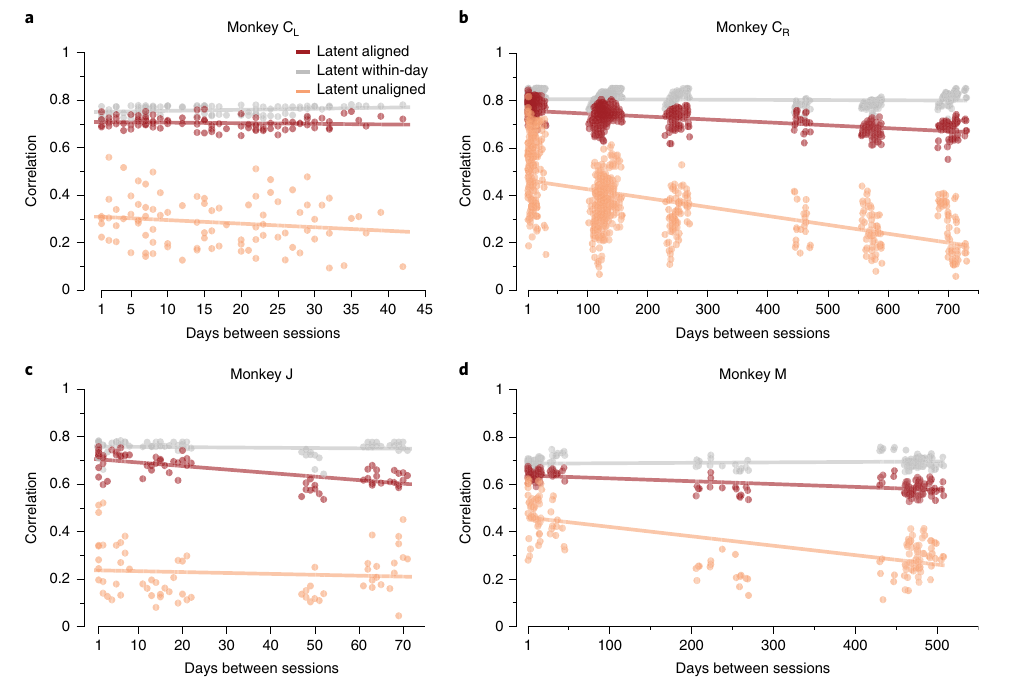  

### Details
- **animal**: $C_L$  is Chewie
- **window**: For *M1* it is $-120ms \sim +420ms$ and for *PMd* from $-390ms  \sim +60ms$
- **dim**: it is 10 for M1 and 15 for PMd
- **preprocessing**: 
    - remove firing rate below 1Hz overall
    - bin to 30ms
    - square root transform
    - smooth by Gaussian kernel, $\sigma=50ms$
    
Let's reproduce the gray dots: within-day CCs for one or two animals

In [4]:
ANIMAL = 'Chewie'
BIN_SIZE = .03  # sec
WINDOW_prep = (-.39, .06)  # sec
WINDOW_exec = (-.12, .42)  # sec
AREA = 'M1'

fileList = [root/ANIMAL/dataset for dataset in GoodDataList[AREA][ANIMAL]]


df_data_M1=[]
for fname in fileList:
    df = dt.load_pyal_data(fname)
    df_data_M1.append(df)
#     dt.summary(df)

In [5]:
def prep_general (df):
    "preprocessing general!"
    time_signals = [signal for signal in pyal.get_time_varying_fields(df) if 'spikes' in signal]
    df["target_id"] = df.apply(get_target_id, axis=1)  # add a field `target_id` with int values

    for signal in time_signals:
        df_ = pyal.remove_low_firing_neurons(df, signal, 1)
    
    df_= pyal.select_trials(df, df.result== 'R')
    df_= pyal.select_trials(df_, df_.epoch=='BL')
    
    assert np.all(df_.bin_size == .01), 'bin size is not consistent!'
    df_ = pyal.combine_time_bins(df_, int(BIN_SIZE/.01))
    for signal in time_signals:
        df_ = pyal.sqrt_transform_signal(df_, signal)
        
    df_= pyal.add_firing_rates(df_, 'smooth', std=0.05)
    
    
    return df_


prep_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on',
                                     rel_start=int(WINDOW_prep[0]/BIN_SIZE),
                                     rel_end=int(WINDOW_prep[1]/BIN_SIZE)
                                    )
exec_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on', 
                                     rel_start=int(WINDOW_exec[0]/BIN_SIZE),
                                     rel_end=int(WINDOW_exec[1]/BIN_SIZE)
                                    )

Finding the minimum number of trials per target across all datasets

and some other parameters

In [6]:
df_M1_ready = [prep_general(df) for  df in df_data_M1]


n_shared_trial = np.inf
data_list = df_M1_ready
n_components = 10
field = f'{AREA}_rates'

for df in data_list:
    for target in range(8):
        df_ = pyal.select_trials(df, df.target_id== target)
        n_shared_trial = np.min((df_.shape[0], n_shared_trial))

n_shared_trial = int(n_shared_trial)
print(f'{n_shared_trial=}')

# finding the number of timepoints
df_ = pyal.restrict_to_interval(df_,epoch_fun=exec_epoch)
n_timepoints = int(df_[field][0].shape[0])
print(f'{n_timepoints=}')

/home/msafaie/REPOS/PyalData/pyaldata/tools.py:934: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/PyalData/pyaldata/tools.py:934: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/PyalData/pyaldata/tools.py:934: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/PyalData/pyaldata/tools.py:934: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


n_shared_trial=17
n_timepoints=19


collecting all the data in a matrix, `AllData`: $sessions \times targets \times  trials \times time \times PCs$

In [7]:
AllData = np.empty((len(data_list), 8, n_shared_trial, n_timepoints, n_components))

print(f'{AllData.shape=}')

rng = np.random.default_rng(12345)
for session, df in enumerate(data_list):
    df_ = pyal.restrict_to_interval(df,epoch_fun=exec_epoch)
    rates = np.concatenate(df_[field].values, axis=0)
    rates -= np.mean(rates,axis=0)
    rates_model = PCA(n_components=n_components, svd_solver='full').fit(rates)
    df_ = pyal.apply_dim_reduce_model(df_, rates_model, field, '_pca');

    for target in range(8):
        df__ = pyal.select_trials(df_, df_.target_id==target)
        all_id = df__.trial_id.to_numpy()
        rng.shuffle(all_id)
        # select the right number of trials to each target
        df__ = pyal.select_trials(df__, lambda trial: trial.trial_id in all_id[:n_shared_trial])
        for trial, trial_rates in enumerate(df__._pca):
            AllData[session,target,trial, :, :] = trial_rates

AllData.shape=(4, 8, 17, 19, 10)


do the CCA calculation

In [8]:
n_iter = 100
trialList = np.arange(n_shared_trial)

CCs=[]
for session, sessionData in enumerate(AllData):
    r = []
    for n in range(n_iter):
        rng.shuffle(trialList)
        # non-overlapping randomised trials
        trial1 = trialList[:n_shared_trial//2]
        trial2 = trialList[-n_shared_trial//2:-1]
        data1 = np.reshape(sessionData[:,trial1,:,:], (-1,n_components))
        data2 = np.reshape(sessionData[:,trial2,:,:], (-1,n_components))
        r.append(np.mean(dt.canoncorr(data1, data2)[:4]))
    CCs.append(r)
CCs = np.array(CCs).T

(0.0, 1.0)

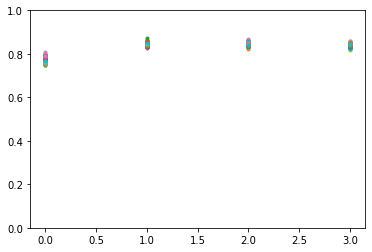

In [9]:
plt.plot(CCs.T,'.')
plt.ylim([0,1])

the average distribution of CCs for each session

In [10]:
n_iter = 100
trialList = np.arange(n_shared_trial)

CCs=[]
for session, sessionData in enumerate(AllData):
    r = []
    for n in range(n_iter):
        rng.shuffle(trialList)
        # non-overlapping randomised trials
        trial1 = trialList[:n_shared_trial//2]
        trial2 = trialList[-(n_shared_trial//2):]
        data1 = np.reshape(sessionData[:,trial1,:,:], (-1,n_components))
        data2 = np.reshape(sessionData[:,trial2,:,:], (-1,n_components))
        r.append(dt.canoncorr(data1, data2))
    CCs.append(np.array(r))
CCs = np.array(CCs).T

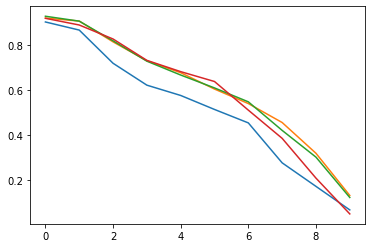

In [11]:
for i in range(4):
    plt.plot(np.mean(CCs[:,:,i],axis=1))

### include all datasets

let's redo the above for all the datasets

In [12]:
warnings.filterwarnings("ignore")

allFileList1 = []
for animal1 in GoodDataList[areas[0]]:
    path1List = [root/animal1/GoodDataList[areas[0]][animal1][i] for i,_ in enumerate(GoodDataList[areas[0]][animal1])]
    for path1 in path1List:
            allFileList1.append(dt.load_pyal_data(path1))

allFileList2 = []
for animal in GoodDataList[areas[1]]:
    path1List = [root/animal/GoodDataList[areas[1]][animal][i] for i,_ in enumerate(GoodDataList[areas[1]][animal])]
    for path1 in path1List:
            allFileList2.append(dt.load_pyal_data(path1))
        
print(f'{len(allFileList1)=}')
print(f'{len(allFileList2)=}')


allFileList1_ready = [prep_general(df1) for  df1 in allFileList1]
allFileList2_ready = [prep_general(df2) for  df2 in allFileList2]

del allFileList1, allFileList2  # to save memory

warnings.filterwarnings("default")

len(allFileList1)=14
len(allFileList2)=10


collecting all the data in a matrix, `AllData`: $sessions \times targets \times  trials \times time \times PCs$

In [13]:
AllData1 = dt.get_data_array(allFileList1_ready, exec_epoch, area='M1', n_components=n_components)
AllData2 = dt.get_data_array(allFileList2_ready, prep_epoch, area='PMd', n_components=n_components)

/home/msafaie/REPOS/multi-monkey-cca/tools/dataTools.py:416: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1157]
  df_ = pyal.restrict_to_interval(df, epoch_fun=epoch)


do the CCA calculation

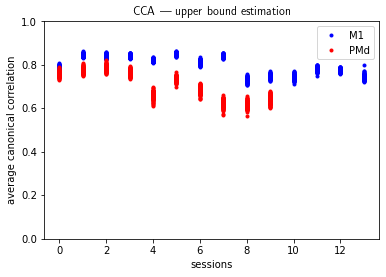

In [14]:
n_iter = 100
n_shared_trial1 = AllData1.shape[2]
n_shared_trial2 = AllData2.shape[2]

trialList1 = np.arange(n_shared_trial1)
trialList2 = np.arange(n_shared_trial2)

rng = np.random.default_rng(12345)
CCs1=[]
for session, sessionData in enumerate(AllData1):
    r = []
    for n in range(n_iter):
        rng.shuffle(trialList1)
        # non-overlapping randomised trials
        trial1 = trialList1[:n_shared_trial1//2]
        trial2 = trialList1[-(n_shared_trial1//2):]
        data1 = np.reshape(sessionData[:,trial1,:,:], (-1,n_components))
        data2 = np.reshape(sessionData[:,trial2,:,:], (-1,n_components))
        r.append(np.mean(dt.canoncorr(data1, data2)[:4]))
    CCs1.append(r)
CCs1 = np.array(CCs1).T

CCs2=[]
for session, sessionData in enumerate(AllData2):
    r = []
    for n in range(n_iter):
        rng.shuffle(trialList2)
        # non-overlapping randomised trials
        trial1 = trialList2[:n_shared_trial2//2]
        trial2 = trialList2[-(n_shared_trial2//2):]
        data1 = np.reshape(sessionData[:,trial1,:,:], (-1,n_components))
        data2 = np.reshape(sessionData[:,trial2,:,:], (-1,n_components))
        r.append(np.mean(dt.canoncorr(data1, data2)[:4]))
    CCs2.append(r)
CCs2 = np.array(CCs2).T



M1_Lines = plt.plot(CCs1.T,'b.', label='M1')
PMd_lines = plt.plot(CCs2.T,'r.', label='PMd')
plt.legend([M1_Lines[-1], PMd_lines[-1]], ['M1','PMd'])
plt.ylim([0,1])
plt.xlabel('sessions')
plt.ylabel('average canonical correlation')
plt.title('CCA --- upper bound estimation', usetex=True);

plotting the CC values.

the lower bound CC values are loaded from `/data/lower-bound-values.npy`

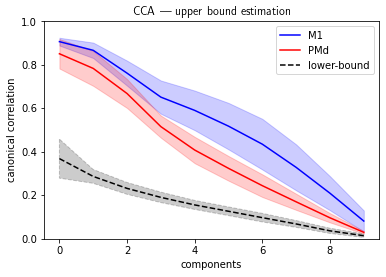

In [15]:
n_iter = 100
n_shared_trial1 = AllData1.shape[2]
n_shared_trial2 = AllData2.shape[2]

trialList1 = np.arange(n_shared_trial1)
trialList2 = np.arange(n_shared_trial2)


CCs1=[]
for session, sessionData in enumerate(AllData1):
    r = []
    for n in range(n_iter):
        rng.shuffle(trialList1)
        # non-overlapping randomised trials
        trial1 = trialList1[:n_shared_trial1//2]
        trial2 = trialList1[-(n_shared_trial1//2):]
        data1 = np.reshape(sessionData[:,trial1,:,:], (-1,n_components))
        data2 = np.reshape(sessionData[:,trial2,:,:], (-1,n_components))
        r.append(dt.canoncorr(data1, data2))
    CCs1.append(r)
CCs1 = np.array(CCs1).mean(axis=1)

CCs2=[]
for session, sessionData in enumerate(AllData2):
    r = []
    for n in range(n_iter):
        rng.shuffle(trialList2)
        # non-overlapping randomised trials
        trial1 = trialList2[:n_shared_trial2//2]
        trial2 = trialList2[-(n_shared_trial2//2):]
        data1 = np.reshape(sessionData[:,trial1,:,:], (-1,n_components))
        data2 = np.reshape(sessionData[:,trial2,:,:], (-1,n_components))
        r.append(dt.canoncorr(data1, data2))
    CCs2.append(r)
CCs2 = np.array(CCs2).mean(axis=1)

CCs_lowerbound = np.load(root/'lower-bound-values.npy')

_,ax = plt.subplots()
M1_Lines,_ = utility.shaded_errorbar(ax, CCs1.T, color='b', label='M1')
PMd_lines,_ = utility.shaded_errorbar(ax, CCs2.T, color='r', label='PMd')
low_line,*_ = utility.shaded_errorbar(ax, CCs_lowerbound, ls='--', color='k', label='lower-bound')

plt.legend(handles=[M1_Lines, PMd_lines,low_line])
plt.ylim([0,1])
plt.xlabel('components')
plt.ylabel('canonical correlation')
plt.title('CCA --- upper bound estimation', usetex=True);